In [1]:
from chainer import Chain, configuration
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam
from chainer.datasets import mnist
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater, Trainer
from chainer.training.extensions import PrintReport, LogReport, Evaluator
from sklearn.model_selection import train_test_split
from chainer import serializers
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

/Users/hiroki.kurasawa/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# データの取得
train_all , test = mnist.get_mnist(ndim=3)

In [28]:
# データサイズの確認
print("train_all_x >>{}".format(train_all._datasets[0].shape))
print("train_all_y >>{}".format(train_all._datasets[1].shape))
print("test_x >>{}".format(test._datasets[0].shape))
print("test_y >>{}".format(test._datasets[1].shape))

train_all_x >>(60000, 1, 28, 28)
train_all_y >>(60000,)
test_x >>(10000, 1, 28, 28)
test_y >>(10000,)


In [26]:
# ラベリングされたものとされていないものに訓練データを分ける
# 5000件のみラベリング済みとし、10,000件はラベリングされていないものとする
num_initial_data = 5000

x_train = train_all._datasets[0][:num_initial_data]
x_train_sub = train_all._datasets[0][num_initial_data:][:10000]
y_train = train_all._datasets[1][:num_initial_data]

In [31]:
# データサイズの確認
print("x_train >>{}".format(x_train.shape))
print("x_train_sub >>{}".format(x_train_sub.shape))
print("y_train >>{}".format(y_train.shape))

x_train >>(5000, 1, 28, 28)
x_train_sub >>(10000, 1, 28, 28)
y_train >>(5000,)


In [74]:
# x_trainとy_trainをマージする関数
def merge_data(x,y):
    return [(x[i,:],y[i]) for i in range(len(x))]

In [39]:
train = merge_data(x_train,y_train)

In [96]:
# モデルの定義
class Model(Chain):
    def __init__(self):
        super(Model,self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(1,16,ksize=3)
            self.batch = L.BatchNormalization(16)
            self.linear = L.Linear(10)
            
    def __call__(self,x):
        h = self.conv(x)
        h = F.relu(h)
        h = F.max_pooling_2d(h,ksize=3)
        h = self.batch(h)
        h = self.linear(h)
        return h

In [97]:
# 学習の実行
model = Model()
# 予め学習させておいたモデルの呼び出し
# serializers.load_npz("model_initial",model)
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)

train_iterator = SerialIterator(train,batch_size=100,repeat=True)
test_iterator = SerialIterator(test,batch_size=100,shuffle=False,repeat=False)
updater = StandardUpdater(train_iterator,optimizer,loss_func=classifier)
trainer = Trainer(updater,(100,'iteration'))
trainer.extend(Evaluator(test_iterator,classifier),trigger=(10,'iteration'),name="test")
trainer.extend(PrintReport(['iteration','main/loss','test/main/loss','main/accuracy','test/main/accuracy']))

logreport =LogReport(trigger=(10,'iteration'))
trainer.extend(logreport)
trainer.run()
serializers.save_npz('model',model)

iteration   main/loss   test/main/loss  main/accuracy  test/main/accuracy
10          1.72315     1.0439          0.43           0.6712              
20          0.773315    0.610828        0.794          0.8335              
30          0.4597      0.470546        0.894          0.8698              
40          0.416224    0.409463        0.888          0.8841              
50          0.342664    0.359958        0.914          0.903               
60          0.255517    0.327181        0.927          0.9114              
70          0.235184    0.317359        0.94           0.9131              
80          0.203972    0.29145         0.951          0.918               
90          0.228116    0.269778        0.939          0.9256              


In [98]:
from sklearn.metrics import classification_report

with configuration.using_config('train',False):
    predicts = model(np.array([data[0] for data in test],dtype=np.float32))
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts,axis=1)

print("****Scores for Test Data ****")
print(classification_report(np.array([data[1] for data in test],dtype=np.float32), predicts_y))

****Scores for Test Data ****
             precision    recall  f1-score   support

        0.0       0.95      0.98      0.96       980
        1.0       0.97      0.98      0.97      1135
        2.0       0.90      0.89      0.90      1032
        3.0       0.90      0.92      0.91      1010
        4.0       0.95      0.93      0.94       982
        5.0       0.92      0.89      0.91       892
        6.0       0.97      0.93      0.95       958
        7.0       0.94      0.91      0.93      1028
        8.0       0.88      0.93      0.90       974
        9.0       0.91      0.92      0.92      1009

avg / total       0.93      0.93      0.93     10000



# 半教師あり学習
少ないデータで学習した分類器に対し、ラベルのないデータで予測を行い、その推論結果をラベリングし学習データにする

# アクティブラーニング
ラベルのないデータで推論を行うまでは半教師あり学習と一緒だが、重要なデータのみ人がラベル付けを行い学習データに取り込むこと

重要なデータの定義は、様々だが今回は予測した結果の上位2番目と1番目の差が小さいものを重要とみなし、人の手でラベル付けをしていく

In [100]:
# softmax関数
def softmax(x):
    exp_x = np.exp(x)
    y = exp_x / np.sum(np.exp(x),axis=1,keepdims=True)
    return y

In [101]:
proba = softmax(model(x_train_sub).data)

In [102]:
# 予測結果の上位2番目と1番目の差分と要素のインデックスを取得する関数
def get_low_margin(proba,bound):
    lm = []
    for i in range(len(proba)):
        margin = proba[i][np.argsort(proba[i])][-1] - proba[i][np.argsort(proba[i])][-2]
        if margin < bound:
            lm.append([i,margin])
    return lm

In [103]:
# 予測結果の高いデータのみを取得
# probaの要素を1つづつ取り出して、boundよりも高いのかを確認しインデックスをリストに追加
def get_high_proba(proba,bound):
    hp =[]
    for i in range(len(proba)):
        for p in range(len(proba[i])):
            if proba[i,p] > bound:
                hp.append([i,p])
    return hp

In [104]:
def getdata_from_index(data,index):
    return data[index]

In [105]:
# 手動でラベリングを行う
def add_label(x_train,index):
    selected_x_train = getdata_from_index(x_train,index)
    labels =[]
    for i,d in enumerate(selected_x_train):
        print("{0}/{1}".format(i+1,selected_x_train.shape[0]))
        plt.imshow(np.reshape(d,[28,28]),cmap="gray_r")
        plt.show()
        label = input("enter label here")
        labels.append(int(label))
    print("finished")
    selected_x_train = selected_x_train[:len(labels)]
    return selected_x_train,labels

In [106]:
# 半教師あり学習とアクティブラーニングによってラベリングしたデータを学習データに加える

def concat_data(proba,x_train,y_train,x_train_sub,proba_limit,margin_limit):
    # ラベル付けされていない要素数を表示
    print("total number of data is {0}".format(x_train_sub.shape[0]))
    # 予測結果が曖昧な要素のインデックスと差分を取得
    lm = get_low_margin(proba,margin_limit)
    hp = get_high_proba(proba,proba_limit)
    # 予測が曖昧（または信頼度の高い）になっている要素数と定義してい条件を表示
    print("number of data with first and second choice probability lower than {0}:{1}".format(margin_limit,len(lm)))
    print("number of data with probabilty higher than {0}:{1}".format(proba_limit,len(hp)))
    
    # 予測が曖昧になっているインデックスの取得
    lm_index = np.array(lm,dtype="int64")[:,0]
    # ラベリングした要素とラベルを取得
    lm_x_train , lm_y_train = add_label(x_train_sub,lm_index)
    
    # 予測結果の信頼度が高いインデックスを取得
    hp_index = np.array(hp,dtype="int64")[:,0]
    hp_x_train = getdata_from_index(x_train_sub,hp_index)
    # 予測結果の信頼度が高いラベルの取得
    hp_y_train = np.array(hp,dtype="int64")[:,1]
    
    # 手動でラベリングしたまたは信頼度が高いと判断された要素のインデックスのデータセットを取得
    selected_index = np.concatenate((lm_index,hp_index))
    # 手動でラベリングしたまたは信頼度が高いと判断された要素のデータセットを取得
    selected_x_train = np.concatenate((lm_x_train,hp_x_train))
    # 手動でラベリングしたまたは信頼度が高いと判断されたラベルを取得
    selected_y_train = np.concatenate((lm_y_train,hp_y_train))
    
    # 手動でラベリングしたまたは信頼度が高いと判断されたデータセットを学習データへ追加
    new_x_train = np.concatenate((x_train,selected_x_train))
    new_y_train = np.concatenate((y_train,selected_y_train))
    # ラベリングされていなかった元のデータから今回ラベリングされたデータを削除する
    new_x_train_sub = np.delete(x_train_sub,selected_index,axis=0)
    
    print("{0} was added to training data".format(selected_x_train.shape[0]))
    
    return new_x_train , new_y_train , new_x_train_sub

total number of data is 532
number of data with first and second choice probability lower than 0.01:9
number of data with probabilty higher than 0.95:9
1/9


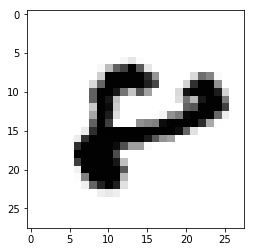

enter label here8
2/9


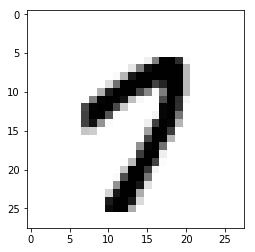

enter label here7
3/9


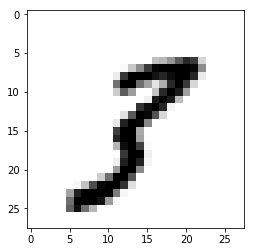

enter label here3
4/9


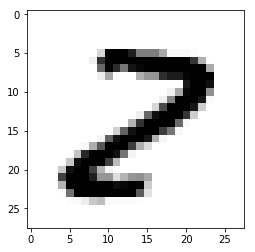

enter label here2
5/9


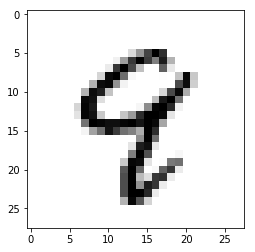

enter label here8
6/9


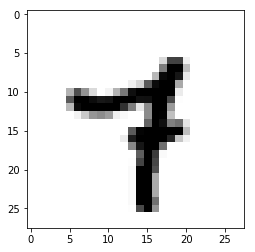

enter label here7
7/9


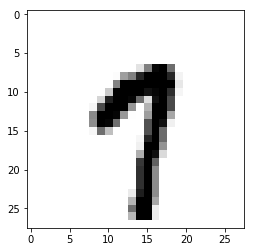

enter label here1
8/9


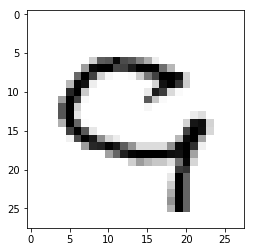

enter label here9
9/9


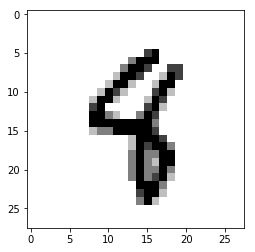

enter label here8
finished
18 was added to training data


In [107]:
x_train , y_train , x_train_sub = concat_data(proba,x_train,y_train,x_train_sub,proba_limit = 0.95,margin_limit = 0.01)

In [108]:
print(x_train.shape)
print(x_train_sub.shape)
print(y_train.shape)

(14486, 1, 28, 28)
(514, 1, 28, 28)
(14486,)


In [109]:
train  = merge_data(x_train,y_train)

In [110]:
# 学習の実行
model = Model()
# 予め学習させておいたモデルの呼び出し
serializers.load_npz("model_initial",model)
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)

train_iterator = SerialIterator(train,batch_size=100,repeat=True)
test_iterator = SerialIterator(test,batch_size=100,shuffle=False,repeat=False)
updater = StandardUpdater(train_iterator,optimizer,loss_func=classifier)
trainer = Trainer(updater,(100,'iteration'))
trainer.extend(Evaluator(test_iterator,classifier),trigger=(10,'iteration'),name="test")
trainer.extend(PrintReport(['iteration','main/loss','test/main/loss','main/accuracy','test/main/accuracy']))

logreport =LogReport(trigger=(10,'iteration'))
trainer.extend(logreport)
trainer.run()
serializers.save_npz('model',model)

iteration   main/loss   test/main/loss  main/accuracy  test/main/accuracy
10          0.01652     0.123169        0.997          0.9632              
20          0.0146801   0.111233        0.998          0.9665              
30          0.0214176   0.115033        0.998          0.9652              
40          0.0176661   0.108189        0.994          0.9674              
50          0.0133107   0.117303        0.997          0.9637              
60          0.01753     0.111126        0.994          0.9678              
70          0.0145309   0.119306        0.998          0.9651              
80          0.013613    0.112471        0.998          0.9671              
90          0.0114545   0.122771        0.996          0.9647              


In [111]:
from sklearn.metrics import classification_report

with configuration.using_config('train',False):
    predicts = model(np.array([data[0] for data in test],dtype=np.float32))
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts,axis=1)

print("****Scores for Test Data ****")
print(classification_report(np.array([data[1] for data in test],dtype=np.float32), predicts_y))

****Scores for Test Data ****
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       980
        1.0       0.99      0.98      0.99      1135
        2.0       0.93      0.97      0.95      1032
        3.0       0.98      0.96      0.97      1010
        4.0       0.97      0.97      0.97       982
        5.0       0.97      0.97      0.97       892
        6.0       0.97      0.98      0.97       958
        7.0       0.97      0.95      0.96      1028
        8.0       0.98      0.93      0.95       974
        9.0       0.94      0.97      0.96      1009

avg / total       0.97      0.97      0.97     10000



total number of data is 514
number of data with first and second choice probability lower than 0.01:5
number of data with probabilty higher than 0.95:48
1/5


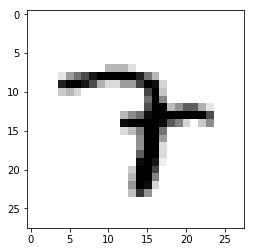

enter label here7
2/5


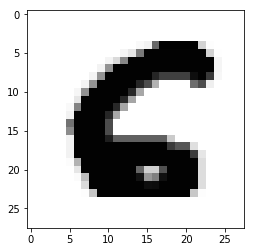

enter label here6
3/5


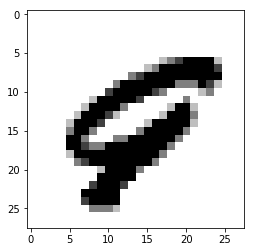

enter label here9
4/5


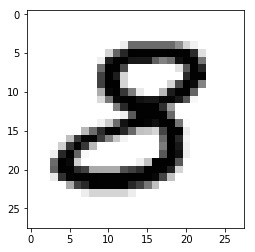

enter label here8
5/5


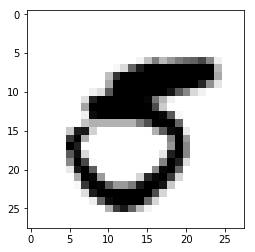

enter label here5
finished
53 was added to training data


In [112]:
proba = softmax(model(x_train_sub).data)
x_train , y_train , x_train_sub = concat_data(proba,x_train,y_train,x_train_sub,proba_limit = 0.95,margin_limit = 0.01)

In [113]:
print(x_train.shape)
print(x_train_sub.shape)
print(y_train.shape)

(14539, 1, 28, 28)
(461, 1, 28, 28)
(14539,)


In [114]:
# 学習の実行
model = Model()
# 予め学習させておいたモデルの呼び出し
serializers.load_npz("model_initial",model)
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)

train_iterator = SerialIterator(train,batch_size=100,repeat=True)
test_iterator = SerialIterator(test,batch_size=100,shuffle=False,repeat=False)
updater = StandardUpdater(train_iterator,optimizer,loss_func=classifier)
trainer = Trainer(updater,(100,'iteration'))
trainer.extend(Evaluator(test_iterator,classifier),trigger=(10,'iteration'),name="test")
trainer.extend(PrintReport(['iteration','main/loss','test/main/loss','main/accuracy','test/main/accuracy']))

logreport =LogReport(trigger=(10,'iteration'))
trainer.extend(logreport)
trainer.run()
serializers.save_npz('model',model)

iteration   main/loss   test/main/loss  main/accuracy  test/main/accuracy
10          0.0133838   0.110723        0.999          0.9663              
20          0.0104877   0.119116        0.999          0.9649              
30          0.0102549   0.119474        0.999          0.9655              
40          0.021159    0.10965         0.995          0.9664              
50          0.0111328   0.117468        0.998          0.966               
60          0.0167834   0.113922        0.997          0.9678              
70          0.016499    0.112428        0.996          0.9672              
80          0.011566    0.122404        0.998          0.9664              
90          0.0111161   0.111876        0.997          0.9684              


In [115]:
from sklearn.metrics import classification_report

with configuration.using_config('train',False):
    predicts = model(np.array([data[0] for data in test],dtype=np.float32))
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts,axis=1)

print("****Scores for Test Data ****")
print(classification_report(np.array([data[1] for data in test],dtype=np.float32), predicts_y))

****Scores for Test Data ****
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       980
        1.0       0.99      0.99      0.99      1135
        2.0       0.97      0.94      0.96      1032
        3.0       0.94      0.98      0.96      1010
        4.0       0.96      0.97      0.97       982
        5.0       0.98      0.94      0.96       892
        6.0       0.95      0.99      0.97       958
        7.0       0.97      0.94      0.96      1028
        8.0       0.96      0.95      0.95       974
        9.0       0.94      0.96      0.95      1009

avg / total       0.96      0.96      0.96     10000



total number of data is 769
number of data with first and second choice probability lower than 0.01:7
number of data with probabilty higher than 0.95:115
1/7


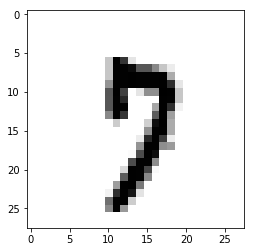

enter label here7
2/7


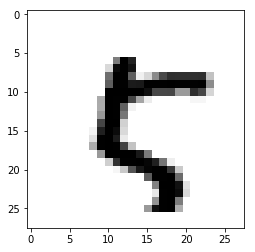

enter label here5
3/7


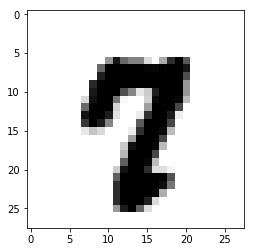

enter label here7
4/7


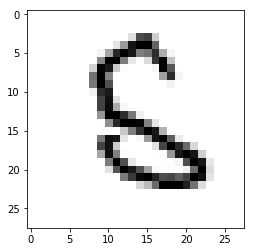

enter label here5
5/7


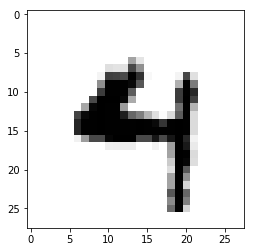

enter label here4
6/7


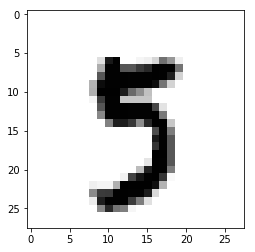

enter label here5
7/7


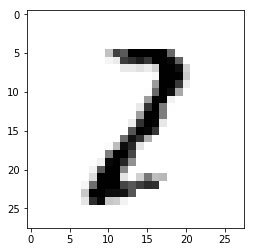

enter label here2
finished
122 was added to training data


In [87]:
proba = softmax(model(x_train_sub).data)
x_train , y_train , x_train_sub = concat_data(proba,x_train,y_train,x_train_sub,proba_limit = 0.95,margin_limit = 0.01)

In [88]:
print(x_train.shape)
print(x_train_sub.shape)
print(y_train.shape)

(14353, 1, 28, 28)
(647, 1, 28, 28)
(14353,)


In [89]:
# 学習の実行
model = Model()
# 予め学習させておいたモデルの呼び出し
serializers.load_npz("model_initial",model)
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)

train_iterator = SerialIterator(train,batch_size=100,repeat=True)
test_iterator = SerialIterator(test,batch_size=100,shuffle=False,repeat=False)
updater = StandardUpdater(train_iterator,optimizer,loss_func=classifier)
trainer = Trainer(updater,(100,'iteration'))
trainer.extend(Evaluator(test_iterator,classifier),trigger=(10,'iteration'),name="test")
trainer.extend(PrintReport(['iteration','main/loss','test/main/loss','main/accuracy','test/main/accuracy']))

logreport =LogReport(trigger=(10,'iteration'))
trainer.extend(logreport)
trainer.run()
serializers.save_npz('model',model)

iteration   main/loss   test/main/loss  main/accuracy  test/main/accuracy
10          0.00698394  0.107705        1              0.9667              
20          0.00477027  0.113395        1              0.9669              
30          0.00758147  0.105269        0.999          0.9682              
40          0.00842737  0.109475        0.999          0.9677              
50          0.00586512  0.122517        0.999          0.9642              
60          0.00348793  0.11355         1              0.9669              
70          0.00528244  0.114916        0.999          0.9668              
80          0.00501651  0.113323        1              0.9666              
90          0.00468417  0.119977        0.999          0.965               


In [90]:
from sklearn.metrics import classification_report

with configuration.using_config('train',False):
    predicts = model(np.array([data[0] for data in test],dtype=np.float32))
predicts = np.array([predict.data for predict in predicts])
predicts_y = np.argmax(predicts,axis=1)

print("****Scores for Test Data ****")
print(classification_report(np.array([data[1] for data in test],dtype=np.float32), predicts_y))

****Scores for Test Data ****
             precision    recall  f1-score   support

        0.0       0.96      0.99      0.98       980
        1.0       0.98      0.99      0.99      1135
        2.0       0.97      0.96      0.96      1032
        3.0       0.95      0.98      0.97      1010
        4.0       0.96      0.98      0.97       982
        5.0       0.97      0.95      0.96       892
        6.0       0.98      0.97      0.98       958
        7.0       0.97      0.96      0.96      1028
        8.0       0.97      0.93      0.95       974
        9.0       0.95      0.96      0.95      1009

avg / total       0.97      0.97      0.97     10000



total number of data is 647
number of data with first and second choice probability lower than 0.01:3
number of data with probabilty higher than 0.95:77
1/3


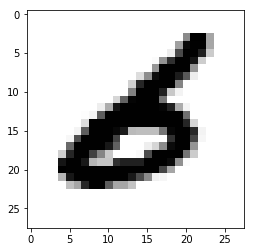

enter label here6
2/3


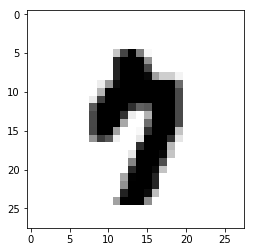

enter label here7
3/3


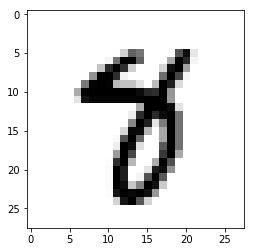

enter label here8
finished
80 was added to training data


In [91]:
proba = softmax(model(x_train_sub).data)
x_train , y_train , x_train_sub = concat_data(proba,x_train,y_train,x_train_sub,proba_limit = 0.95,margin_limit = 0.01)

In [92]:
# 学習の実行
model = Model()
# 予め学習させておいたモデルの呼び出し
serializers.load_npz("model_initial",model)
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)

train_iterator = SerialIterator(train,batch_size=100,repeat=True)
test_iterator = SerialIterator(test,batch_size=100,shuffle=False,repeat=False)
updater = StandardUpdater(train_iterator,optimizer,loss_func=classifier)
trainer = Trainer(updater,(100,'iteration'))
trainer.extend(Evaluator(test_iterator,classifier),trigger=(10,'iteration'),name="test")
trainer.extend(PrintReport(['iteration','main/loss','test/main/loss','main/accuracy','test/main/accuracy']))

logreport =LogReport(trigger=(10,'iteration'))
trainer.extend(logreport)
trainer.run()
serializers.save_npz('model',model)

iteration   main/loss   test/main/loss  main/accuracy  test/main/accuracy
10          0.00451389  0.113683        1              0.9674              
20          0.00622301  0.115984        1              0.9665              
30          0.00492899  0.107887        0.999          0.9697              
40          0.0048724   0.105367        1              0.9699              
50          0.00613212  0.11973         1              0.965               
60          0.00647282  0.107785        0.998          0.9683              
70          0.00549109  0.110902        1              0.9675              
80          0.00692155  0.116338        0.999          0.9661              
90          0.00488936  0.114009        1              0.9669              


total number of data is 567
number of data with first and second choice probability lower than 0.01:4
number of data with probabilty higher than 0.95:31
1/4


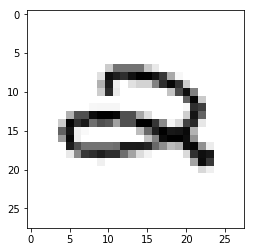

enter label here2
2/4


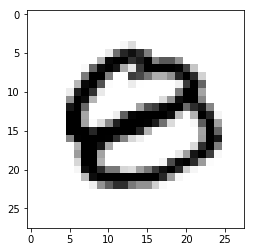

enter label here8
3/4


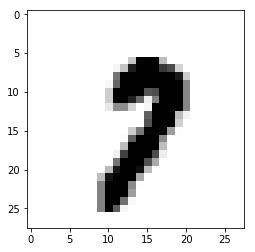

enter label here7
4/4


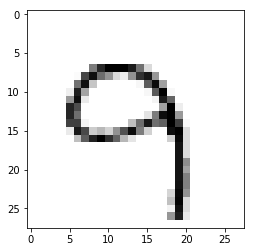

enter label here9
finished
35 was added to training data


In [93]:
proba = softmax(model(x_train_sub).data)
x_train , y_train , x_train_sub = concat_data(proba,x_train,y_train,x_train_sub,proba_limit = 0.95,margin_limit = 0.01)

In [94]:
# 学習の実行
model = Model()
# 予め学習させておいたモデルの呼び出し
serializers.load_npz("model_initial",model)
classifier = L.Classifier(model)
optimizer = Adam()
optimizer.setup(classifier)

train_iterator = SerialIterator(train,batch_size=100,repeat=True)
test_iterator = SerialIterator(test,batch_size=100,shuffle=False,repeat=False)
updater = StandardUpdater(train_iterator,optimizer,loss_func=classifier)
trainer = Trainer(updater,(100,'iteration'))
trainer.extend(Evaluator(test_iterator,classifier),trigger=(10,'iteration'),name="test")
trainer.extend(PrintReport(['iteration','main/loss','test/main/loss','main/accuracy','test/main/accuracy']))

logreport =LogReport(trigger=(10,'iteration'))
trainer.extend(logreport)
trainer.run()
serializers.save_npz('model',model)

iteration   main/loss   test/main/loss  main/accuracy  test/main/accuracy
10          0.00701181  0.107896        0.999          0.9665              
20          0.00950507  0.111017        0.999          0.9678              
30          0.00667346  0.131462        1              0.962               
40          0.00776424  0.113915        0.999          0.9669              
50          0.00679318  0.112285        0.999          0.9679              
60          0.00838407  0.121676        0.999          0.9648              
70          0.0053012   0.121877        1              0.9643              
80          0.00491775  0.115356        0.999          0.9673              
90          0.00324423  0.107636        1              0.9695              
